In [1]:
%matplotlib inline
import waves
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

plt.rcParams['font.size'] = 14

A/D conversion
=============

In [2]:
CD = waves.CDFormatSampler('CD')

SACD = waves.DSDSampler('SACD', 64 * 44100, 16)

# DVD possible combinations (16-, 20- or 24-bits per sample)
# Channels                          | 44.1 kHz | 48 kHz | 88.2 kHz | 96 kHz | 176.4 kHz | 192 kHz
# Mono (1.0)                        |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.0)                      |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.1)                      |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# S+M surround (3.0 or 3.1)         |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Quad (4.0 or 4.1)                 |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo (3.0 or 3.1)             |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo+M surround (4.0 or 4.1)  |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Full surround (5.0 or 5.1)        |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
DVDA = waves.PCMSampler('DVD Audio', 88200, 20)

# High Fidelity Blu-ray Pure Audio uses 24 bits at 192 kHz (or also 96 kHz)
BDA = waves.HFPALinearPCM('Blu-Ray Audio')

# Generic PCM samplers
# Define sampling frequency (Hz) and resolution (bits) to your heart's content
ADC_list = []
for sampler, freq, bits in [
    ('PCM 1', 44100, 4),   # Same CD frequency, lower resolution
    #('PCM 2', 14000, 16),  # Same CD resolution, lower frequency
]:
    ADC_list.append(waves.PCMSampler(sampler, freq, bits))

In [3]:
dither_setup = {
    'nodither': {
        'state': False,
        'label': 'Without dither',
        'c': 'C1',
        'w': 3,
    },
    'dither': {
        'state': True,
        'label': 'With dither',
        'c': 'C0',
        'w': 1,
    },
}

In [19]:
f = 1.2e3 # in Hertz, i.e., 1.2 KHz
audio = waves.AnalogSineWave('analog', f, gain=1, phase=0, infinity=600)
n_waves = 40
length = n_waves * 1/f # in seconds

Let us see how the noise behaves without and with dither added:

PCM 1's stream without dither (16 levels): [7 8 9 10 ... 3 4 5 6]
PCM 1's stream with dither (16 levels): [8 8 10 11 ... 4 4 5 7]


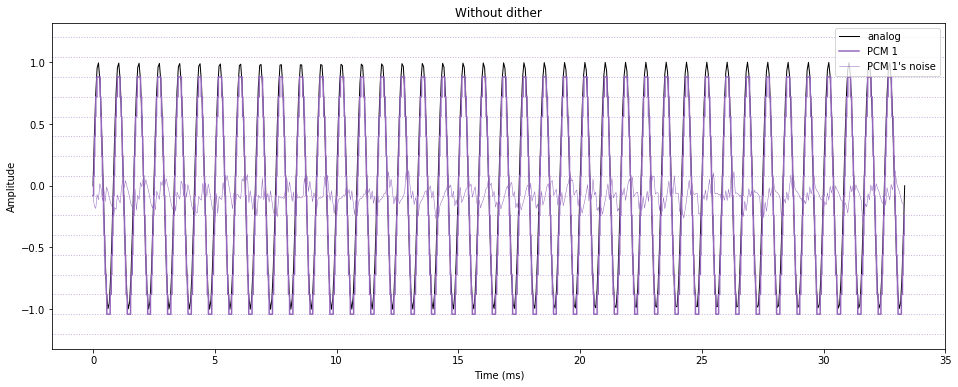

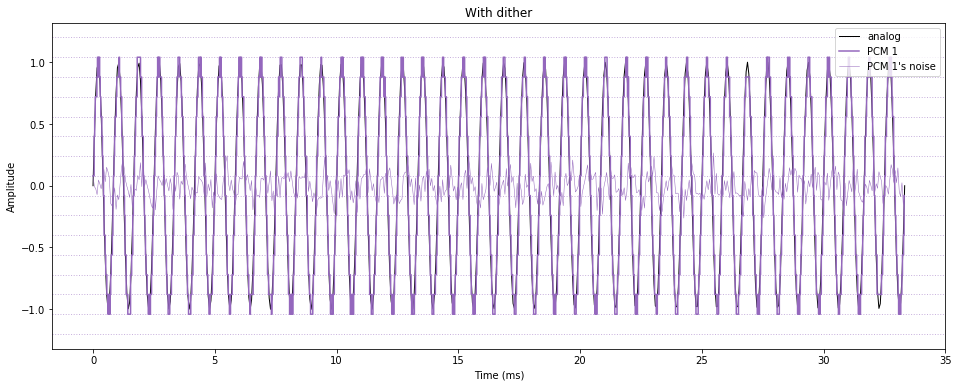

In [21]:
digi_signal = {}
noise_signal = dict([(k, {}) for k in dither_setup.keys()])

for dithering, setup in dither_setup.items():
    fig, ax = plt.subplots()
    digi_signal[dithering] = dict([(ADC.label, {}) for ADC in ADC_list])
    noise_signal[dithering]['time_domain'] = audio.plot(length, plt, color='k', lw=1)
    for ADC in ADC_list:
        unsigned, digi_signal[dithering][ADC.label]['time_domain'], digi_signal[dithering][ADC.label]['signal'], _, noise_signal[dithering][ADC.label] = ADC.sample(audio, length, ax, dither=setup['state'], lw=1.5)
        print(waves.of(ADC.label), 'stream', setup['label'].lower(), 
              '(%i levels):' % ADC.levels, waves.shortlist(unsigned)
             )
        
    # Show grid of ADC with the lowest sampling frequency:
    ADC = sorted(ADC_list, key=lambda ADC: ADC.sampling_frequency)[0]
    # but only if not many sampling intervals:
    if length/ADC.sampling_interval <= 100:
        [ax.axvline(t*1000, color=ADC.color, lw=1, ls=':', alpha=0.5) for t in np.arange(0, length, ADC.sampling_interval)]
    
    # Show grid of ADC with the lowest resolution:
    ADC = sorted(ADC_list, key=lambda ADC: ADC.amplitude_resolution)[0]
    # but only if no more than 4-bit, since too many levels
    if ADC.amplitude_resolution <= 4:
        [ax.axhline(A, color=ADC.color, lw=1, ls=':', alpha=0.5) for A in np.linspace(ADC.amp_min, ADC.amp_max, ADC.levels)]
    
    ax.legend()
    ax.set_title(setup['label'])
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Time (ms)')
    fig.set_size_inches(16, 6)

The noise is more decorrelated from the signal when dither is added. However, this comes at the cost of increased noise power:

In [22]:
def show_noise_signal_correlation(signal, dither_setup, noises, ADC):
    fig, ax = plt.subplots(1, 2)
    for dithering, setup in dither_setup.items():
        analog = signal.function(noises[dithering]['time_domain'])
        ax[0].scatter(analog, noises[dithering][ADC.label], color=setup['c'], label=setup['label'])
        ax[1].plot(*waves.twopar_correlation(noises[dithering][ADC.label], analog), color=setup['c'], lw=setup['w'], label=setup['label'])
    ax[0].legend()
    ax[0].set_xlabel('Signal amplitude')
    ax[0].set_ylabel('Noise amplitude')
    ax[1].set_ylim(-1, 1)
    ax[1].grid(alpha=0.5)
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Signal-noise correlation')
    ax[1].legend()
    fig.suptitle(ADC.label)
    fig.set_size_inches(16, 6)

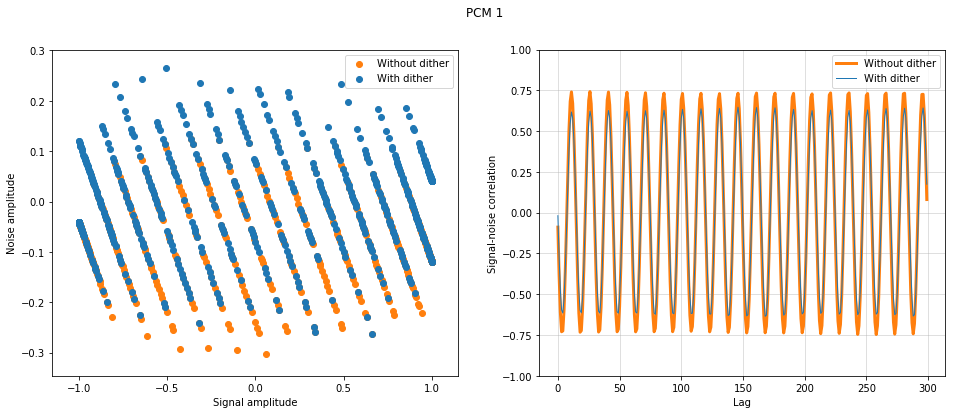

In [23]:
for ADC in ADC_list:
    show_noise_signal_correlation(audio, dither_setup, noise_signal, ADC)

PCM 2 is unaffected, probably because of the high resolution, but for PCM 1 we can see that the correlation is reduced although the noise amplitude has enhanced.

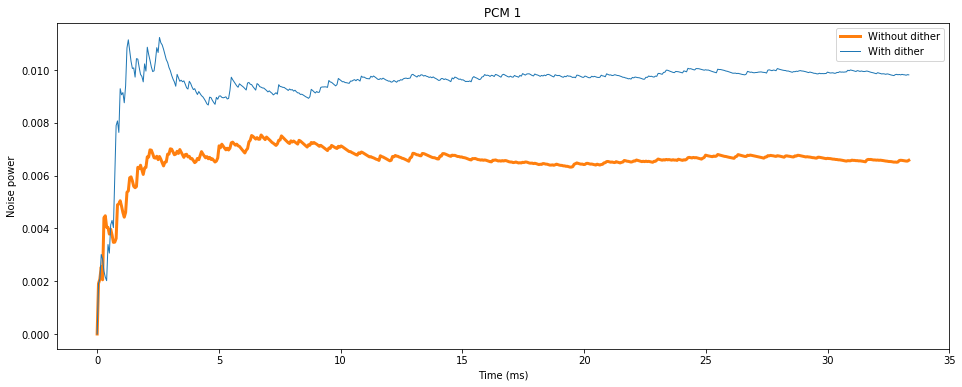

In [24]:
for ADC in ADC_list:
    fig, ax = plt.subplots()
    for dithering, setup in dither_setup.items():
        ax.plot(noise_signal[dithering]['time_domain']*1000, 
                [st.moment(noise_signal[dithering][ADC.label][:t+1], moment=2) for t in range(len(noise_signal[dithering]['time_domain']))], 
                color=setup['c'], lw=setup['w'], label=setup['label'])
        ax.set_title(ADC.label)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Noise power')
        ax.legend()
        fig.set_size_inches(16, 6)

Here we can also see, for PCM 1, that the introduction of dither enhanced the total noise power.
Let us also have a look at the Fourier transform of the signals.

In [9]:
from scipy.fftpack import rfft, rfftfreq, fftshift

In [25]:
digi_signal['dither']['PCM 1']['signal']-digi_signal['nodither']['PCM 1']['signal']

array([0.16, 0.  , 0.16, ..., 0.  , 0.  , 0.16])

In [28]:
def fourier(dither_setup, digi_signal, ADC):
    style = iter([('C1', 3), ('C0', 1)])
    fig, ax = plt.subplots()
    for dithering, setup in dither_setup.items():
        t = digi_signal[dithering][ADC.label]['time_domain']
        yf = rfft(digi_signal[dithering][ADC.label]['signal'])
        tf = rfftfreq(digi_signal[dithering][ADC.label]['time_domain'].size, d=ADC.sampling_interval)
        c, w = next(style)
        print(list(zip(tf, yf)))
        print(list(zip(tf[1::2], yf[1::2])))
        ax.vlines(tf[1::2]/1000, 0, np.abs(yf[1::2]), color=setup['c'], lw=setup['w'], label=setup['label'])
        #plt.plot(tf[1::2]/1000, np.abs(yf[1::2]), lw=1, label=label)
    ax.legend()
    #ax.set_xscale('log')
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('Amplitude')
    ax.set_title(ADC.label)
    ax.grid(which='both', alpha=0.5)
    fig.set_size_inches(16, 6)

[(0.0, -117.59999999999992), (30.0, -7.563805458215525e-15), (30.0, 5.072850091880984e-15), (60.0, 1.2549833535889144e-14), (60.0, -2.0340556073229692e-14), (90.0, 2.3094572732853958e-15), (90.0, 7.599663972499198e-15), (120.0, 4.28618468878349e-15), (120.0, 6.112093302276547e-15), (150.0, -8.321972658578634e-15), (150.0, -1.491862189340054e-14), (180.0, 1.8246572734720092e-15), (180.0, -1.4354489146767523e-15), (210.0, -2.004847329332837e-15), (210.0, 8.284064966837698e-16), (240.0, -7.009398980640566e-16), (240.0, 3.1377797643634294e-15), (270.0, -6.211567939838599e-15), (270.0, 1.4780187100634603e-16), (300.0, 1.1608784717559021e-15), (300.0, 19.156725828950258), (330.0, 1.6083788709015563e-15), (330.0, -2.8911774286167027e-15), (360.0, 3.537340139284105e-14), (360.0, 1.941459513398068e-14), (390.0, 3.249490014013592e-16), (390.0, -2.961691049330736e-15), (420.0, 7.079076752624556e-15), (420.0, -7.496506417931065e-15), (450.0, 1.5513645372005661e-15), (450.0, 1.6653345369377348e-15)

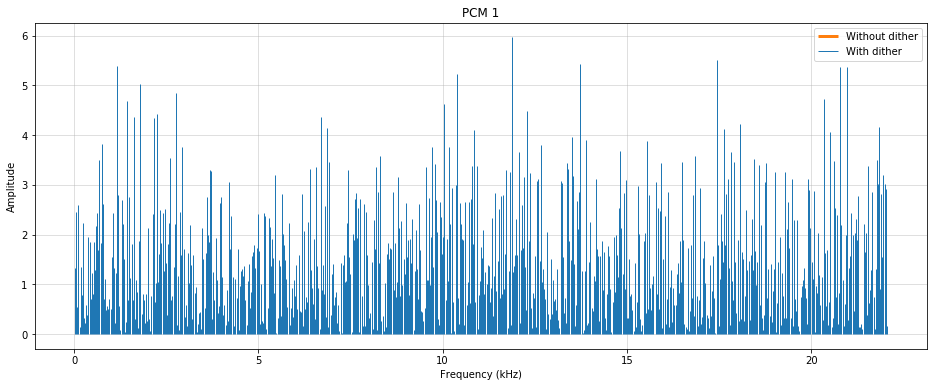

In [29]:
for ADC in ADC_list:
    fourier(dither_setup, digi_signal, ADC)

In [13]:
from math import floor

In [14]:
d = np.random.uniform(0, 1, 200000)

In [15]:
I = np.array([floor(i) for i in d + 4.8])

In [16]:
I[np.logical_and(I != 4, I != 5)]

array([], dtype=int64)

In [17]:
I[I == 4].size/I.size

0.199885

In [18]:
I[I == 5].size/I.size

0.800115